In [ ]:
import pandas as pd
import numpy as np
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import o
# ajout du chemin src
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path: sys.path.append(project_root)
from src.data_prep import load_and_feature_engineering, reduce_mem_usage, missing_values_table

In [ ]:
# On charge Train et Test pour avoir le même encodage
df = pd.read_csv('../data/application_train.csv')
test = pd.read_csv('../data/application_test.csv')
df = pd.concat([df, test], ignore_index=True)

In [ ]:
# On vire tout ce qui concerne l'habitat c'est les colonnes avec AVG, MODE, MEDI 
cols_to_drop = [c for c in df.columns if '_AVG' in c or '_MODE' in c or '_MEDI' in c]
# On vire les FLAG_DOCUMENT 
cols_to_drop.extend([c for c in df.columns if 'FLAG_DOCUMENT' in c])
# On vire les infos de contact social inutiles
cols_to_drop.extend(['FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE'])

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Correction Outliers (Revenu et Jours travaillés) 
df = df[df['AMT_INCOME_TOTAL'] < 100000000] # Vire le 117M
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True) # Vire les 1000 ans
# en gros le days employed se fait a partir du jours ou on a demandé le pret donc si c'est positif c'est que c'est dans le futur donc on vire aussi.
df.shape

C:\Users\aubin\AppData\Local\Temp\ipykernel_33992\2998761460.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True) # Vire les 1000 ans


(356254, 55)

In [4]:
# Ratios Financiers (colonne créées dans les codes kaggle et le code du prof)
df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

# Interactions EXT_SOURCE (Les plus puissantes)
df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['EXT_SOURCE_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['EXT_SOURCE_1_x_DAYS_BIRTH'] = df['EXT_SOURCE_1'] * df['DAYS_BIRTH']
df.shape

(356254, 63)

In [5]:
# jointure avec bureau tout les credits externes
bureau = pd.read_csv('../data/bureau.csv')
# On veut savoir la DETTE ACTUELLE TOTALE
bureau['ACTIVE_LOANS'] = (bureau['CREDIT_ACTIVE'] == 'Active').astype(int)
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM_DEBT': ['sum', 'max'], # Combien il doit ailleurs ?
    'CREDIT_DAY_OVERDUE': ['max'],         # Max retard ailleurs
    'ACTIVE_LOANS': ['mean']               # % de crédits actifs
})
bureau_agg.columns = ['BUREAU_DEBT_SUM', 'BUREAU_DEBT_MAX', 'BUREAU_OVERDUE_MAX', 'BUREAU_ACTIVE_RATIO']
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')
del bureau, bureau_agg; gc.collect()
df.shape

(356254, 67)

In [6]:
# jointure avec previous historique interne
prev = pd.read_csv('../data/previous_application.csv')
# Taux de refus passé
prev['REFUSED'] = (prev['NAME_CONTRACT_STATUS'] == 'Refused').astype(int)
prev_agg = prev.groupby('SK_ID_CURR').agg({
    'REFUSED': ['mean'],        # A-t-il été refusé souvent ?
    'AMT_ANNUITY': ['mean'],    # Combien il payait avant ?
    'CNT_PAYMENT': ['mean']     # Durée moyenne demandée
})
prev_agg.columns = ['PREV_REFUSED_RATIO', 'PREV_ANNUITY_MEAN', 'PREV_TERM_MEAN']
df = df.merge(prev_agg, on='SK_ID_CURR', how='left')
del prev, prev_agg; gc.collect()
df.shape

(356254, 70)

In [7]:
# jointure avec installement + collonne créer dans le code du prof
ins = pd.read_csv('../data/installments_payments.csv')

# 1. PAYMENT_PERC : Pourcentage payé par rapport au dû
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
# On gère les infinis si division par 0
ins['PAYMENT_PERC'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. PAYMENT_DIFF : Montant prescrit - Montant payé (Positif = Moins payé que prévu)
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

# 3. diff_days : Différence brute
ins['DIFF_DAYS'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']

# 4. DPD (Days Past Due) : Retard (clip à 0 min)
ins['DPD'] = ins['DIFF_DAYS'].clip(lower=0)

# 5. DBD (Days Before Due) : Avance (clip à 0 min)
ins['DBD'] = (-ins['DIFF_DAYS']).clip(lower=0)

# 6. DPD_FLAG : Est-ce un retard ? (0 ou 1)
ins['DPD_FLAG'] = (ins['DPD'] > 0).astype(int)

# Agrégation par client
ins_agg = ins.groupby('SK_ID_CURR').agg({
    'PAYMENT_PERC': ['mean', 'var'],    # Comportement de remboursement
    'PAYMENT_DIFF': ['sum', 'mean'],    # Combien il manque au total
    'DPD': ['max', 'mean', 'sum'],      # Analyse des retards
    'DBD': ['max', 'mean'],             # Analyse des avances
    'DPD_FLAG': ['mean']                # Taux d'incidents (ex: 0.1 = 10% de retards)
})

# Renommage propre des colonnes
ins_agg.columns = ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()]

df = df.merge(ins_agg, on='SK_ID_CURR', how='left')
del ins, ins_agg; gc.collect()
df.shape

C:\Users\aubin\AppData\Local\Temp\ipykernel_33992\3234184041.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ins['PAYMENT_PERC'].replace([np.inf, -np.inf], np.nan, inplace=True)


(356254, 80)

In [8]:
# jointure avec pos cash pour les credit conso
pos = pd.read_csv('../data/POS_CASH_balance.csv')
pos_agg = pos.groupby('SK_ID_CURR').agg({
    'SK_DPD': ['max'], # Max jours de retard
    'CNT_INSTALMENT_FUTURE': ['sum'] # Dette restante (nombre de traites)
})
pos_agg.columns = ['POS_DPD_MAX', 'POS_FUTURE_DEBT']
df = df.merge(pos_agg, on='SK_ID_CURR', how='left')
del pos, pos_agg; gc.collect()
df.shape

(356254, 82)

In [9]:
#jointure avec credit card balance
cc = pd.read_csv('../data/credit_card_balance.csv')
cc_agg = cc.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean'],      # Solde moyen
    'AMT_DRAWINGS_ATM_CURRENT': ['mean'], # Retraits cash (signe de besoin)
    'SK_DPD': ['max']             # Retard carte
})
cc_agg.columns = ['CC_BALANCE_MEAN', 'CC_ATM_DRAWINGS_MEAN', 'CC_DPD_MAX']
df = df.merge(cc_agg, on='SK_ID_CURR', how='left')
del cc, cc_agg; gc.collect()
df.shape

(356254, 85)

In [10]:
# reduction de la taille en memoire
df = reduce_mem_usage(df)

Usage mémoire initial du DataFrame: 231.03 MB
Usage mémoire final du DataFrame: 86.30 MB
Mémoire réduite de 62.6 %


In [ ]:
# Encodage avec le label encoder pour avoir moins de colonne que avec get dummies ca donne 100 colonnes de plus sinon
le = LabelEncoder()
le_count = 0

for col in df.columns:
    if df[col].dtype == 'object':
        # Si c'est du texte, on transforme
        df[col] = df[col].astype(str)
        
        # On transforme le texte en nombres (0, 1, 2...)
        df[col] = le.fit_transform(df[col])
        le_count += 1

print(f"{le_count} colonnes ont été encodées (pas de nouvelles colonnes créées).")


12 colonnes ont été encodées (pas de nouvelles colonnes créées).


In [12]:
# Gestion des caractères spéciaux dans les noms de colonnes (pour LightGBM)
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
df.shape

(356254, 85)

--- 1. Check Infinis : 0 valeurs infinies détectées ---

--- 2. Top 10 des colonnes vides (%) ---
CC_ATM_DRAWINGS_MEAN         79.735245
CC_BALANCE_MEAN              70.931414
CC_DPD_MAX                   70.931414
OWN_CAR_AGE                  66.031539
EXT_SOURCE_PROD              62.618806
EXT_SOURCE_1                 54.430266
EXT_SOURCE_1_x_DAYS_BIRTH    54.430266
EXT_SOURCE_3                 19.545886
DAYS_EMPLOYED                18.146603
DAYS_EMPLOYED_PERCENT        18.146603
dtype: float64

--- 3. Vérification des Outliers Métier ---
Revenu Max : 18,000,090
ALERTE : Il y a des revenus > 10 Millions. À vérifier !
Jours Travaillés Max (devrait être <= 0) : 0.0


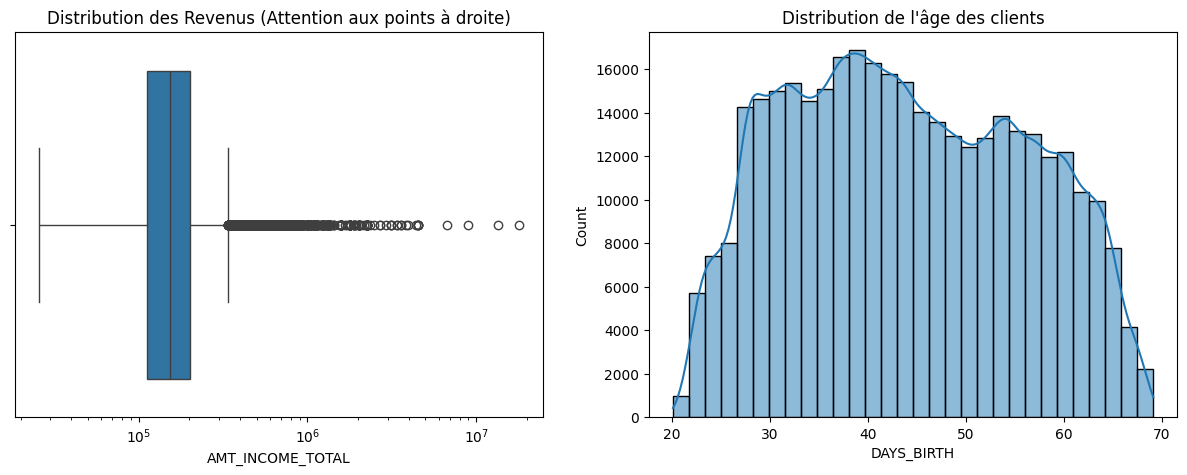

In [ ]:
# --- ANALYSE SANTÉ DU DATASET ---

# 1. Vérification des Infinis (Crucial après création de ratios !)
# Si on divise par 0, ça crée 'inf'
# On ne regarde que les colonnes numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns
inf_count = np.isinf(df[numeric_cols]).sum().sum()

print(f"--- 1. Check Infinis : {inf_count} valeurs infinies détectées ---")
if inf_count > 0:
    # Affiche les colonnes coupables
    cols_with_inf = [col for col in numeric_cols if np.isinf(df[col]).sum() > 0]
    print(f"Colonnes concernées : {cols_with_inf}")
    # Correction simple : on remplace inf par NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("Correction appliquée : inf -> NaN")

# 2. Vérification des Valeurs Manquantes (Top 10)
print("\n--- 2. Top 10 des colonnes vides (%) ---")
missing_perc = (df.isnull().sum() / len(df)) * 100
print(missing_perc.sort_values(ascending=False).head(10))

# 3. Détection des Outliers (Revenus et Emploi)
print("\n--- 3. Vérification des Outliers Métier ---")
# A. Revenus
print(f"Revenu Max : {df['AMT_INCOME_TOTAL'].max():,.0f}")
if df['AMT_INCOME_TOTAL'].max() > 10000000:
    print("ALERTE : Il y a des revenus > 10 Millions. À vérifier !")

# B. Jours Travaillés (Le bug des 1000 ans, soit 365243 jours)
# Si ton nettoyage précédent a marché, le max devrait être négatif (ex: -100 jours) ou 0.
print(f"Jours Travaillés Max (devrait être <= 0) : {df['DAYS_EMPLOYED'].max()}")

# 4. Visualisation Rapide (Boxplot)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1 : Distribution des Revenus (Log scale pour mieux voir)
plt.subplot(1, 2, 1)
sns.boxplot(x=df['AMT_INCOME_TOTAL'])
plt.title('Distribution des Revenus (Attention aux points à droite)')
plt.xscale('log') # On met en log car les écarts sont énormes

# Plot 2 : Distribution de l'âge (en années)
plt.subplot(1, 2, 2)
sns.histplot(df['DAYS_BIRTH'] / -365, bins=30, kde=True)
plt.title("Distribution de l'âge des clients")

plt.show()

Ici les colonnes vide sont importante ca donne plein d'info si on utile 

In [ ]:
#split de train et test
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

# #sauvegarde des fichiers pour moi
# train_df.to_pickle('../data/train_v2.pkl')
# test_df.to_pickle('../data/test_v2.pkl') 

In [23]:
# Analyse du dataset final 
print(f"Dataset final : {train_df.shape[0]:,} lignes et {train_df.shape[1]:,} colonnes.")


Dataset final : 307,510 lignes et 85 colonnes.


In [24]:
# split X et y
X = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Valid shape: {X_test.shape}")

Train shape: (246008, 83), Valid shape: (61502, 83)


In [25]:
from sklearn.metrics import confusion_matrix
# Métrique de coût métier personnalisée ratio 10:1 (FN:FP)
def business_cost_metric(y_true, y_pred_proba, threshold=0.5):
    
    # Convertir probas en classes 0/1 selon le seuil
    y_pred = (y_pred_proba > threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Formule du coût
    cost = 10 * fn + 1 * fp
    # Plus c'est bas, mieux c'est.
    return cost

In [29]:
# dummy de ref et enregistrement dans mlflow
import mlflow
import mlflow.sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

mlflow.set_experiment("Credit_Scoring_Models")

mlflow.autolog()
with mlflow.start_run(run_name="Baseline_Dummy"):
        dummy = DummyClassifier(strategy='most_frequent')

        dummy.fit(X_train, y_train)

        y_prob = dummy.predict_proba(X_test)[:, 1]

        # métriques
        auc_score = roc_auc_score(y_test, y_prob)
        accuracy = accuracy_score(y_test, (y_prob > 0.5).astype(int))
        cost_score = business_cost_metric(y_test, y_prob)
        
        mlflow.log_metric("custom_business_cost", cost_score)
        mlflow.log_metric("custom_auc", auc_score)
        mlflow.log_metric("custom_accuracy", accuracy)

        print(f"Dummy AUC: {auc_score:.2f}")  
        print(f"Dummy Accuracy: {accuracy:.2f}")   
        print(f"Dummy Cost: {cost_score}") 



2025/12/04 19:23:04 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Scoring_Models' does not exist. Creating a new experiment.
2025/12/04 19:23:08 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/12/04 19:23:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\aubin\Majeur IA\data analysis\credit-scoring\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values 

Dummy AUC: 0.50
Dummy Accuracy: 0.92
Dummy Cost: 49650


Accuracy (92%) : Score trompeur ici ; le modèle a juste appris à dire "Oui" à tout le monde et rate 100% des fraudes car il y a 8% de fraude.
AUC (0.5 sur 1) : Le vrai score technique, mesure la capacité du modèle à classer correctement un client risqué par rapport à un sûr.
Coût Métier : La réalité financière, calculée ici en pénalisant 10 fois plus un défaut non détecté (perte sèche) qu'une fausse alerte.

In [ ]:
# On passe a LightGBM 
import lightgbm as lgb

with mlflow.start_run(run_name="LightGBM_Balanced"):
    
    start_time = pd.Timestamp.now()
    # class_weight='balanced' gère automatiquement le déséquilibre 92/8
    lgbm = lgb.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    print("Entraînement LightGBM en cours...")
    lgbm.fit(X_train, y_train)
    end_time = pd.Timestamp.now()
    duration = (end_time - start_time).total_seconds()
    y_prob = lgbm.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, y_prob)
    cost_score = business_cost_metric(y_test, y_prob)
    
    mlflow.log_metric("custom_business_cost", cost_score)
    mlflow.log_metric("custom_auc", auc_score)
    
    # Sauvegarde du modèle
    mlflow.sklearn.log_model(lgbm, "model")
    
    print(f"LGBM AUC: {auc_score:.2f}")   
    print(f"LGBM Cost: {cost_score}")    
    print(f"Training Duration: {duration:.2f} seconds")
mlflow.end_run()

2025/12/04 19:35:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


Entraînement LightGBM en cours...


2025/12/04 19:35:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\aubin\Majeur IA\data analysis\credit-scoring\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


[LightGBM] [Info] Number of positive: 19859, number of negative: 226149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10736
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


2025/12/04 19:35:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\aubin\Majeur IA\data analysis\credit-scoring\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/04 19:35:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/04 19:35:

LGBM AUC: 0.77
LGBM Cost: 31654
Training Duration: 28.70 seconds


AUC 0.77 vs 0.50 (Dummy) : le modèle classe correctement les risques.

Target 0.81 : les vainqueurs Kaggle sont autour de 0.80 - 0.81.

Coût metier : LightGBM 31 654 vs Dummy 50 000

Gain de 36% donc autant de pertes financières pour la banque en moins

Meilleur Seuil : 0.46
Coût Minimal : 31321.0
Gain par rapport au seuil 0.5 : 333 points


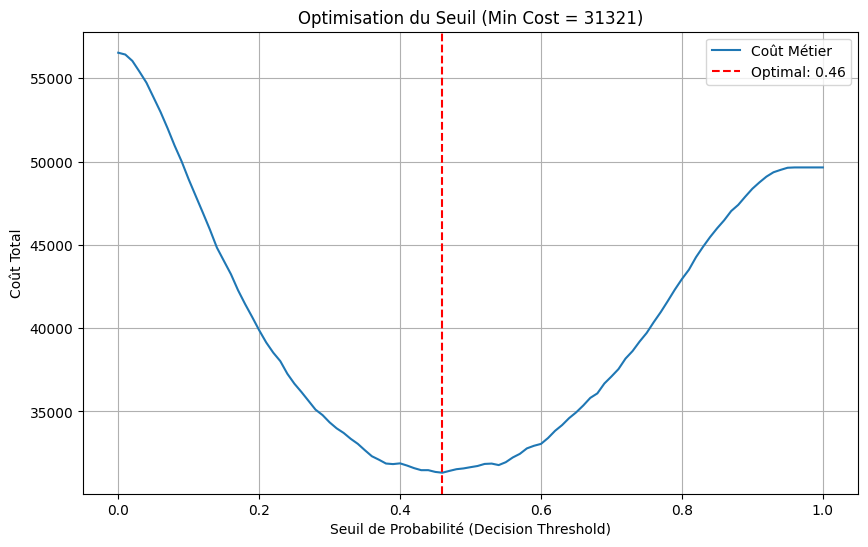

In [ ]:
# OPTIMISATION DU SEUIL 

# On récupère les probabilités prédites
thresholds = np.linspace(0, 1, 101) # On teste de 0.00 à 1.00
costs = []

# 2. On calcule le coût pour chaque seuil
for t in thresholds:
    cost = business_cost_metric(y_test, y_prob, threshold=t)
    costs.append(cost)

# 3. On trouve le meilleur
best_index = np.argmin(costs)
best_threshold = thresholds[best_index]
best_cost = costs[best_index]

print(f"Meilleur Seuil : {best_threshold:.2f}")
print(f"Coût Minimal : {best_cost:.1f}")
print(f"Gain par rapport au seuil 0.5 : {cost_score - best_cost} points")

# Graphique (Demandé dans le rapport)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, label='Coût Métier')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Optimal: {best_threshold:.2f}')
plt.title(f'Optimisation du Seuil (Min Cost = {best_cost:.0f})')
plt.xlabel('Seuil de Probabilité (Decision Threshold)')
plt.ylabel('Coût Total')
plt.legend()
plt.grid(True)
plt.savefig('../reports/figures/courbe_cout_vs_seuil.png') # Sauvegarde pour le rapport
plt.show()


la courbe montre l'évolution du coût financier total pour la banque (pertes sur impayés et manque à gagner) en fonction du seuil de probabilité choisi pour accorder un crédit. Le point le plus bas de la courbe indique le seuil de décision optimal, c'est-à-dire le réglage qui minimise les pertes d'argent en arbitrant au mieux entre le risque de défaut et l'opportunité commerciale. etant donné qu'on a mis en parametre class_weight='balanced' le modele a deja optimiser son entrainement pour pénaliser fortement les erreurs sur les mauvais payeurs. donc le changement de seuil nous permet juste d'optimiser encore un plus

In [34]:
import optuna

#Définition de la fonction objective qu'Optuna doit optimiser
def objective(trial):
    # Espace de recherche (Hyperparameters Search Space)
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': 'balanced', 
        'n_jobs': -1,
        
        # Paramètres à tester
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0), # Régularisation L1
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0), # Régularisation L2
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    # Entraînement avec ces paramètres
    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train)
    
    # Prédiction
    preds = model.predict_proba(X_test)[:, 1]
    
    # On optimise sur le Coût Métier (on veut le MINIMISER)
    # Optuna minimise par défaut si on ne précise pas, ou on peut retourner l'AUC (à maximiser)
    cost = business_cost_metric(y_test, preds)
    
    return cost

#etude
print("Démarrage de l'optimisation Optuna...")
study = optuna.create_study(direction='minimize') # On veut minimiser le coût
study.optimize(objective, n_trials=20) # 20 essais (augmente si tu as le temps)


print(f"Meilleur Coût trouvé : {study.best_value}")
print("Meilleurs paramètres :")
print(study.best_params)

# Enregistrement du meilleur modèle dans MLflow
best_params = study.best_params
# On remet les params fixes
best_params['class_weight'] = 'balanced'
best_params['random_state'] = 42

with mlflow.start_run(run_name="LightGBM_Optuna_Best"):
    # Entraînement final avec les champions
    best_model = lgb.LGBMClassifier(**best_params)
    best_model.fit(X_train, y_train)
    
    # Prédictions
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Métriques finales
    final_auc = roc_auc_score(y_test, y_prob)
    final_cost = business_cost_metric(y_test, y_prob)
    
    # Logs
    mlflow.log_params(best_params)
    mlflow.log_metric("custom_auc", final_auc)
    mlflow.log_metric("custom_business_cost", final_cost)
    mlflow.sklearn.log_model(best_model, "model")
    
    print(f"Final Optimized Model -> AUC: {final_auc:.4f}, Cost: {final_cost}")

[I 2025-12-04 19:56:51,004] A new study created in memory with name: no-name-308c69d8-25e9-47c5-8b3f-24840b2187ac
2025/12/04 19:56:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cd32eff08b474ee793ba2000096da77a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


Démarrage de l'optimisation Optuna...


2025/12/04 19:57:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\aubin\Majeur IA\data analysis\credit-scoring\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/04 19:57:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\aubin\Majeur

Meilleur Coût trouvé : 30835.0
Meilleurs paramètres :
{'n_estimators': 189, 'learning_rate': 0.06145866697369475, 'num_leaves': 78, 'max_depth': 12, 'reg_alpha': 4.367470332764687, 'reg_lambda': 8.770939961985476, 'subsample': 0.6791298274216706, 'colsample_bytree': 0.5703341531974293}


2025/12/04 20:03:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\aubin\Majeur IA\data analysis\credit-scoring\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/04 20:03:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\aubin\Majeur

Final Optimized Model -> AUC: 0.7800, Cost: 30835


Meilleur Coût trouvé : 30835.0
Meilleurs paramètres :
{'n_estimators': 189, 'learning_rate': 0.06145866697369475, 'num_leaves': 78, 'max_depth': 12, 'reg_alpha': 4.367470332764687, 'reg_lambda': 8.770939961985476, 'subsample': 0.6791298274216706, 'colsample_bytree': 0.5703341531974293}

Final Optimized Model -> AUC: 0.7800, Cost: 30835